In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [3]:
sns.set_context('poster')
sns.set_style('white')

In [4]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [5]:
df = pd.read_pickle('CCPA.pkl.gz')
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [6]:
lagsdf = pd.read_pickle('growth_lag.pkl.gz')
exp_decline_df = pd.read_pickle('exponential_decline.pkl.gz')

In [7]:
lagsdf.columns, exp_decline_df.columns

(Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
        'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
        'log10cells0', 'intercept', 'coef', 'r2', 'L', 'initialcells',
        'initiallogcells', 'initiallog10cells', 'L_init', 'e1 coef',
        'e1 L_init', 'L_init_e1coef', 'maxday_e1',
        'max day diff (actual - computed)'],
       dtype='object'),
 Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
        'exponential_popt_0', 'exponential_popt_1', 'exponential_popt_2',
        'rmse_exponential', 'rmse_exponential_60', 'rmse_exponential_5',
        'bic_exponential', 'harmonic_popt_0', 'harmonic_popt_1',
        'harmonic_popt_2', 'rmse_harmonic', 'rmse_harmonic_60',
        'rmse_harmonic_5', 'bic_harmonic', 'p'],
       dtype='object'))

In [8]:
cdf = pd.merge(lagsdf, exp_decline_df, 
               on=['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',])

In [9]:
cdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'maxday', 'minday', 'maxlogcells', 'maxcells', 'logcells0',
       'log10cells0', 'intercept', 'coef', 'r2', 'L', 'initialcells',
       'initiallogcells', 'initiallog10cells', 'L_init', 'e1 coef',
       'e1 L_init', 'L_init_e1coef', 'maxday_e1',
       'max day diff (actual - computed)', 'exponential_popt_0',
       'exponential_popt_1', 'exponential_popt_2', 'rmse_exponential',
       'rmse_exponential_60', 'rmse_exponential_5', 'bic_exponential',
       'harmonic_popt_0', 'harmonic_popt_1', 'harmonic_popt_2',
       'rmse_harmonic', 'rmse_harmonic_60', 'rmse_harmonic_5', 'bic_harmonic',
       'p'],
      dtype='object')

In [10]:
cdf = cdf.loc[:, [
    'experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
    'maxday', 'maxlogcells', 
    #'maxcells',
    'logcells0',
    #'intercept',
    'coef', 'r2', 'L', 
    #'initialcells',
    'initiallogcells', 'L_init', 
    'exponential_popt_0',
    'rmse_exponential',
    'harmonic_popt_0', 
    'rmse_harmonic', ]]

In [11]:
cdf.rename(columns={
    'maxday' : 'Max Day', 
    'maxlogcells' : 'ln(Max Cells) (fit)', 
    'maxcells' : 'Max Cells (fit)',
    'logcells0' : 'ln(Init Cells) (fit)',
    'intercept' : 'intercept (growth)', 
    'coef' : 'Growth rate', 
    'r2' : 'r2 (growth fit)', 
    'L' : 'Lag (fit)', 
    'initialcells' : 'Init Cells (FCM)',
    'initiallogcells' : 'ln(Init Cells) (FCM)',
    'L_init' : 'Lag (FCM)', 
    'exponential_popt_0' : 'Decline Rate',
    'rmse_exponential' : 'Decline RMSE',
    'harmonic_popt_0' : 'harmonic decline rate', 
    'rmse_harmonic' : 'harmonic decline RMSE', 
}, inplace=True)

In [12]:
cdf.isna().sum()

experiment                 0
sample                     0
PRO                        0
ALT                        0
culture                    0
experiment_sample          0
Max Day                    0
ln(Max Cells) (fit)        0
ln(Init Cells) (fit)       0
Growth rate                0
r2 (growth fit)            0
Lag (fit)                  0
ln(Init Cells) (FCM)     154
Lag (FCM)                154
Decline Rate               0
Decline RMSE               0
harmonic decline rate      0
harmonic decline RMSE      0
dtype: int64

Text(0.5,1,'Correlation of cells/growth/decline (all samples)')

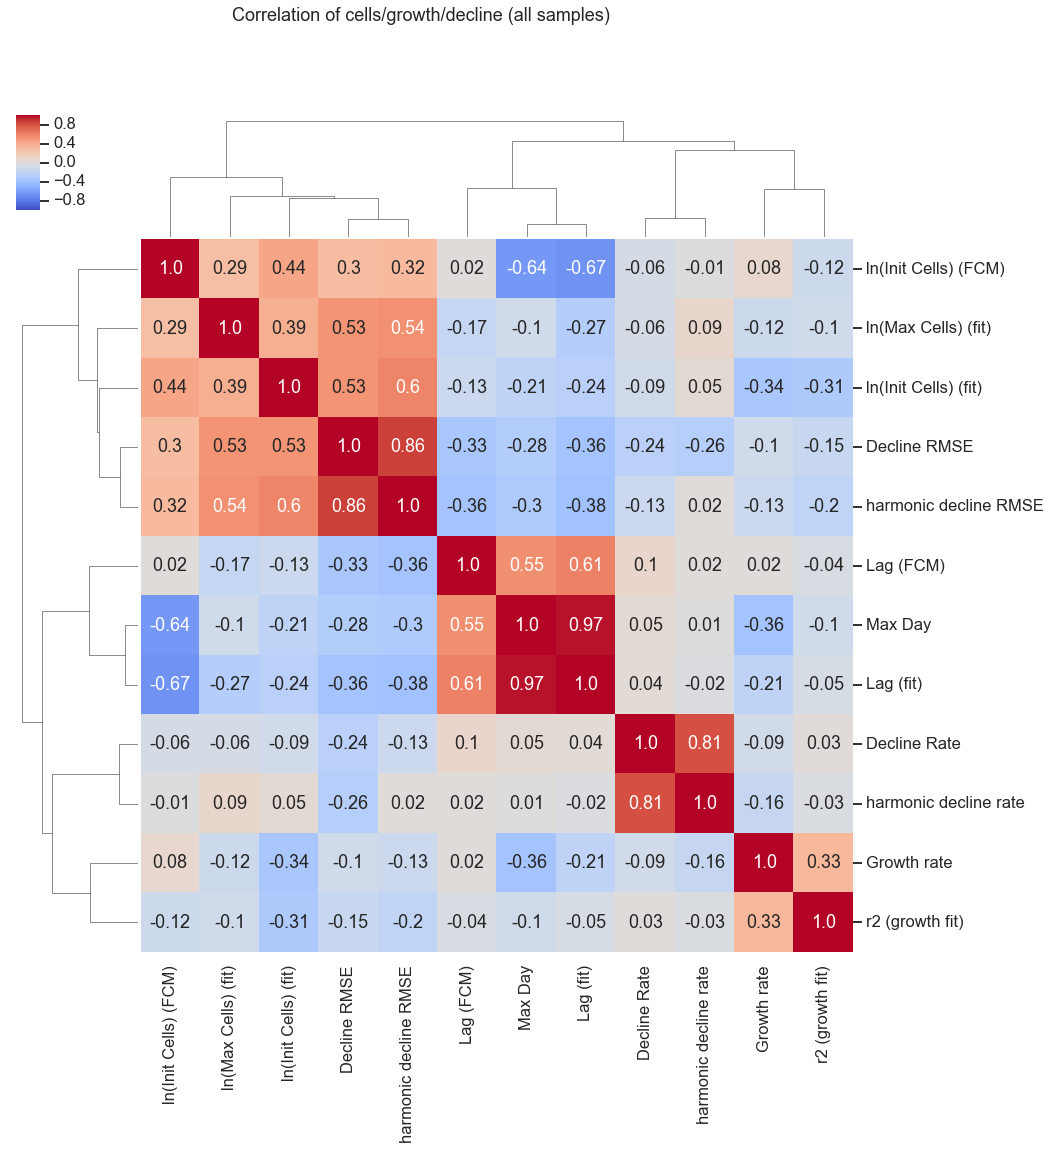

In [13]:
sns.set_style('white')
sns.set_context('talk')
sns.clustermap((cdf.corr().round(2)), 
            figsize=(15,15),
            cmap='coolwarm', annot=True,  fmt='.2',
            vmin=-1, vmax=1,
           )
plt.suptitle('Correlation of cells/growth/decline (all samples)', y=1)
#plt.title('pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')

Text(0.5,1,'Correlation of cells/growth/decline (Axenic)')

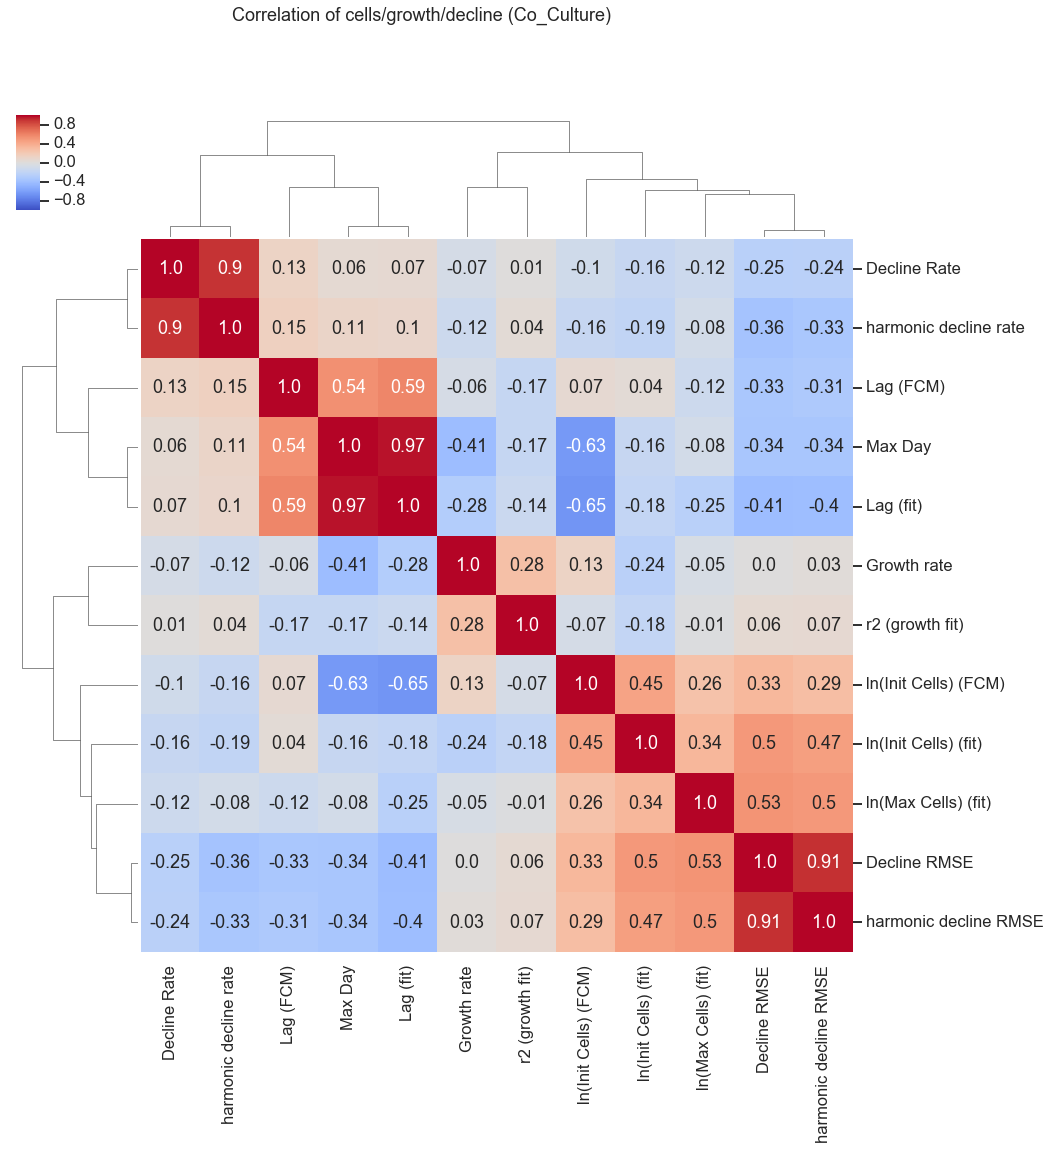

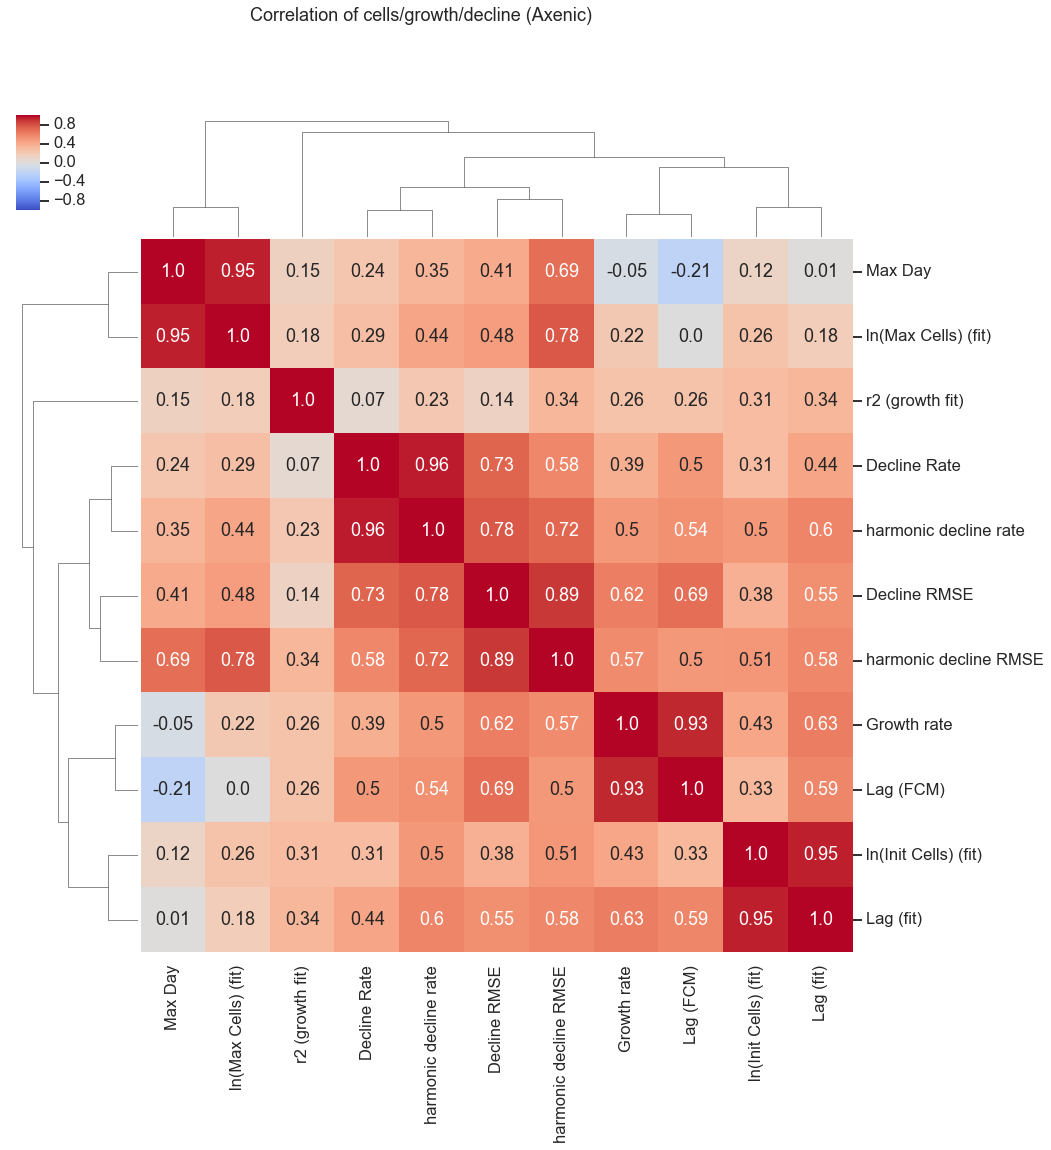

In [14]:
sns.set_style('white')
sns.set_context('talk')
c= 'Co_Culture'
sns.clustermap((cdf.loc[cdf.culture.isin([c])].corr().round(2)), 
            figsize=(15,15),
            cmap='coolwarm', annot=True,  fmt='.2',
            vmin=-1, vmax=1,
           )
plt.suptitle(f'Correlation of cells/growth/decline ({c})', y=1)
#plt.title('pearson correlation of FL, ALT cells, PRO cells,\n experiment 1 days 60,100,140')
c= 'Axenic'
sns.clustermap((cdf.loc[cdf.culture.isin([c])].drop('ln(Init Cells) (FCM)', axis=1).corr().round(2)), 
            figsize=(15,15),
            cmap='coolwarm', annot=True,  fmt='.2',
            vmin=-1, vmax=1,
           )
plt.suptitle(f'Correlation of cells/growth/decline ({c})', y=1)


Text(0.5,1,'Correlation of cells/growth/decline (Co_Culture, e1)')

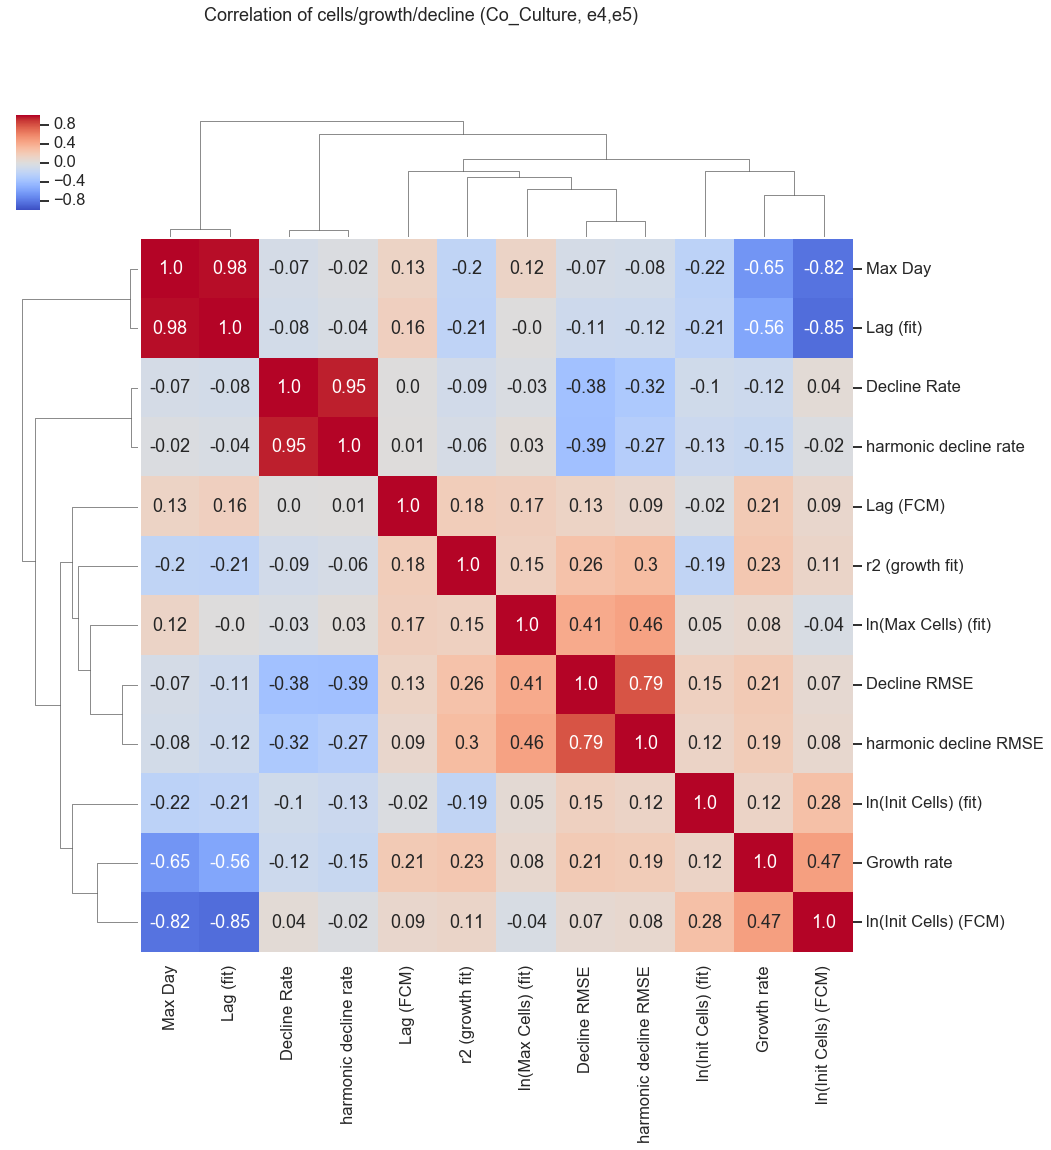

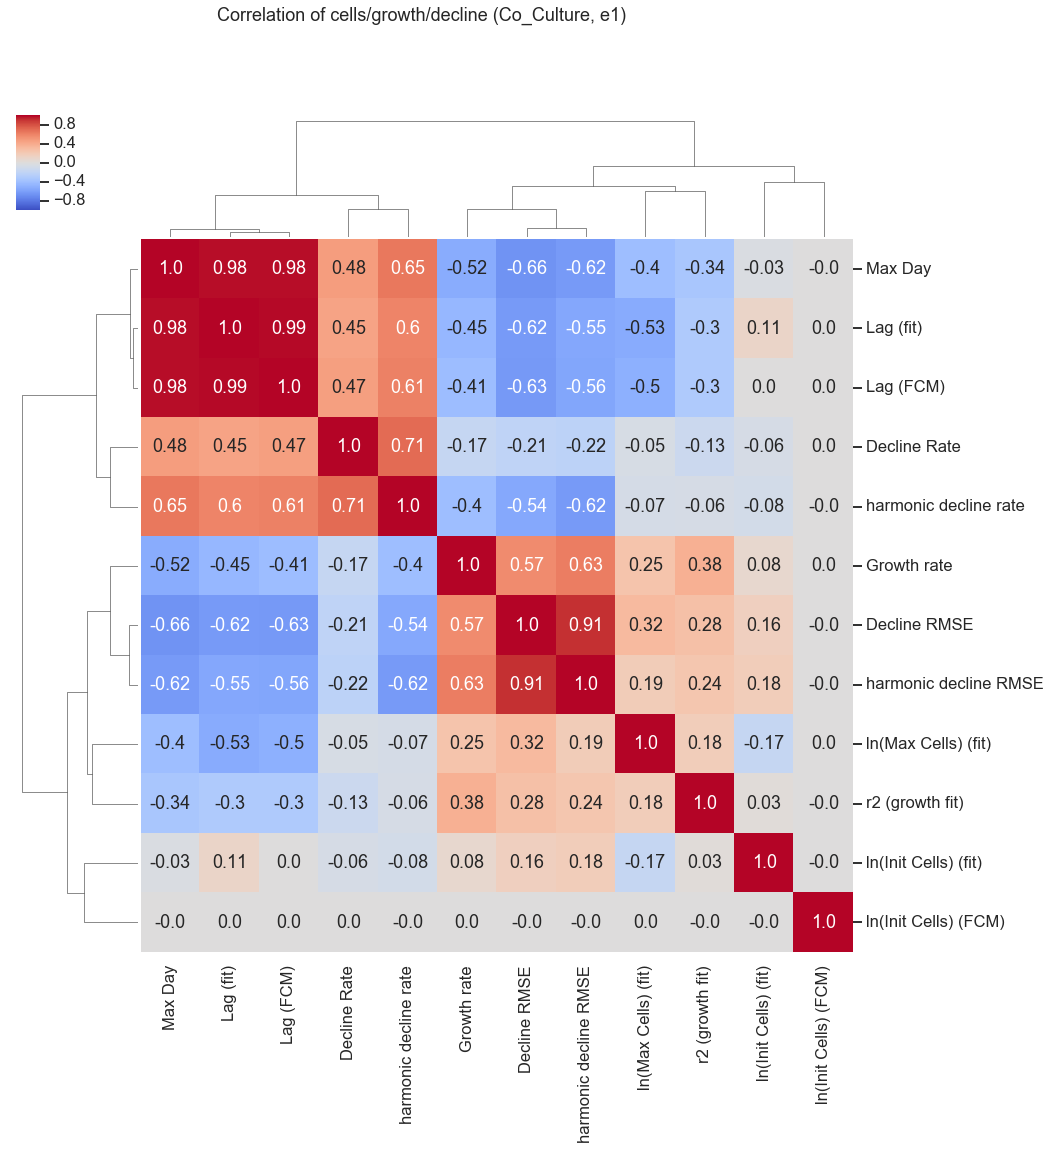

In [31]:
sns.set_style('white')
sns.set_context('talk')
c= 'Co_Culture'
sns.clustermap((cdf.loc[cdf.culture.isin([c]) & cdf.experiment.isin(['e4','e5'])].corr().round(2)), 
            figsize=(15,15),
            cmap='coolwarm', annot=True,  fmt='.2',
            vmin=-1, vmax=1,
           )
plt.suptitle(f'Correlation of cells/growth/decline ({c}, e4,e5)', y=1)
sns.clustermap((cdf.loc[cdf.culture.isin([c]) & cdf.experiment.isin(['e1'])].corr().round(2)), 
            figsize=(15,15),
            cmap='coolwarm', annot=True,  fmt='.2',
            vmin=-1, vmax=1,
           )
plt.suptitle(f'Correlation of cells/growth/decline ({c}, e1)', y=1)


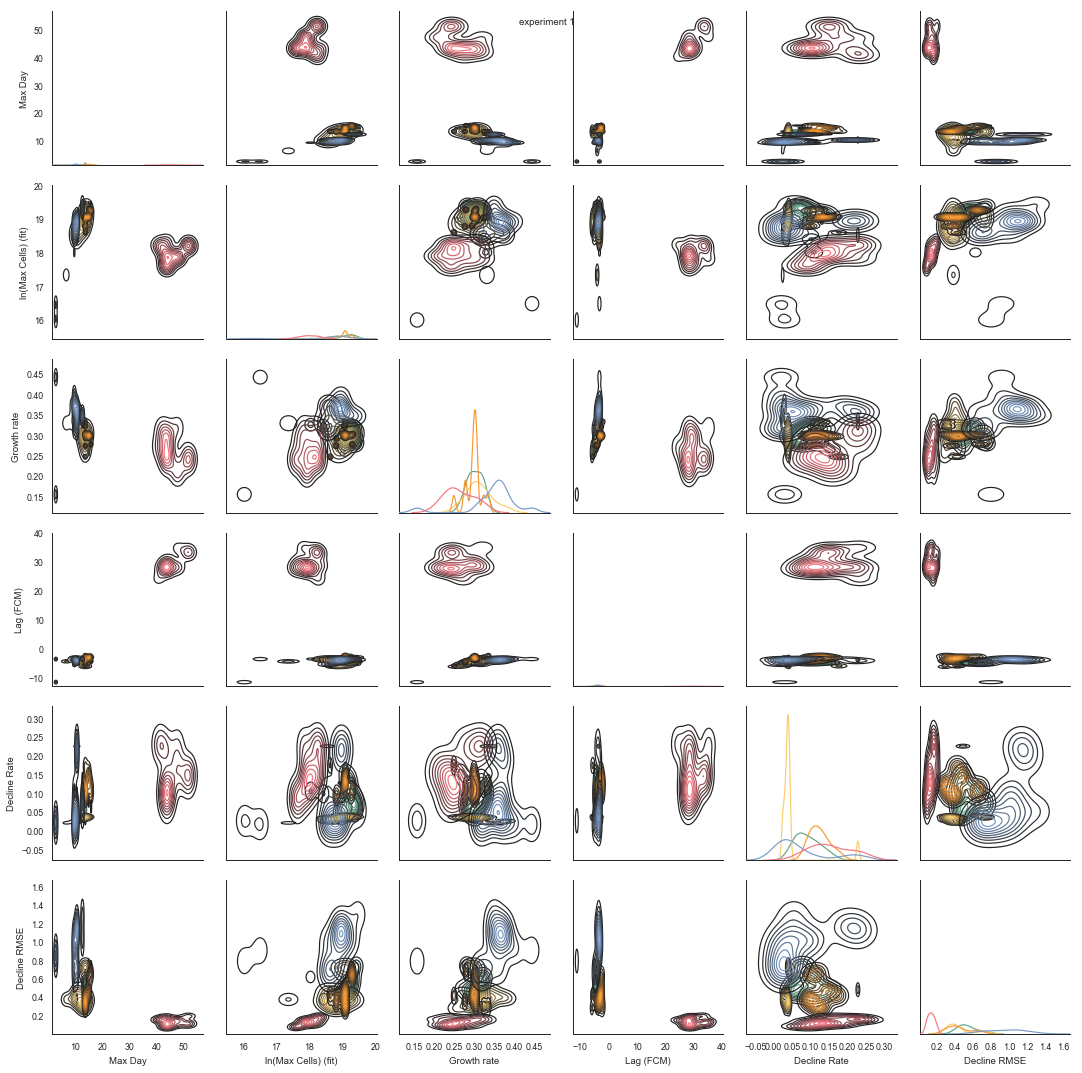

In [21]:
#sns.pairplot(data=cdf.loc[cdf.culture.isin(['Co_Culture']) & cdf.experiment.isin(['e1'])])
sns.set_context('paper')
g = sns.PairGrid(cdf.loc[cdf.culture.isin(['Co_Culture']) & cdf.experiment.isin(['e1']),
                         ['Max Day', 'ln(Max Cells) (fit)', #'ln(Init Cells) (fit)', 
                          'Growth rate',
       #'r2 (growth fit)',  #'ln(Init Cells) (FCM)',
                          'Lag (FCM)',
       'Decline Rate', 'Decline RMSE', 'PRO']
                        ], 
                 hue="PRO", #hue_kws={"cmap": ["Blues", "Greens", "Reds"]}
                 hue_order=porder, palette=ppallete,
                )
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(sns.kdeplot)
plt.suptitle('experiment 1')
plt.show()

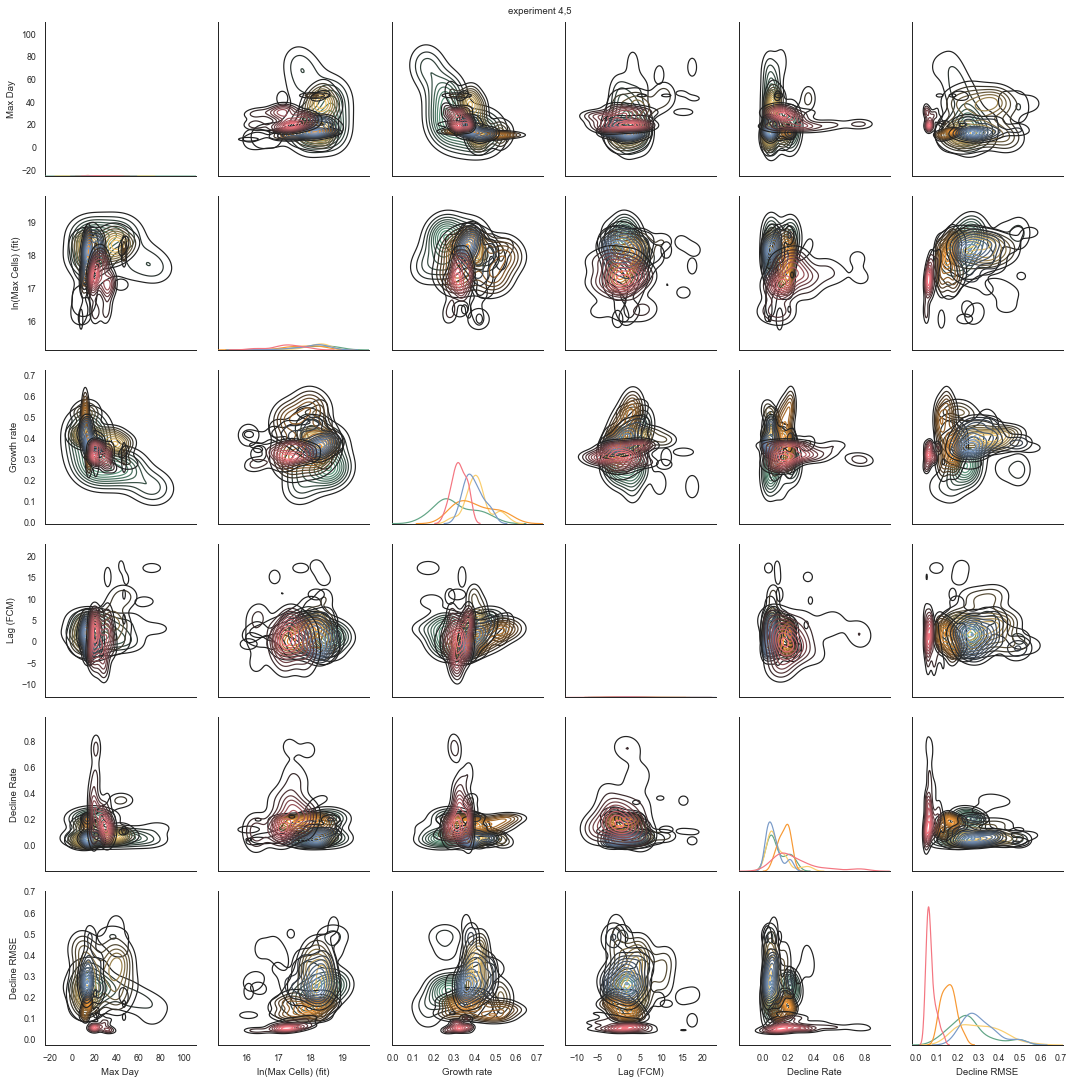

In [26]:
#sns.pairplot(data=cdf.loc[cdf.culture.isin(['Co_Culture']) & cdf.experiment.isin(['e1'])])
sns.set_context('paper')
g = sns.PairGrid(cdf.loc[cdf.culture.isin(['Co_Culture']) & cdf.experiment.isin(['e4', 'e5']) 
                         & (cdf['Lag (FCM)'] >-10),
                         ['Max Day', 'ln(Max Cells) (fit)', #'ln(Init Cells) (fit)', 
                          'Growth rate',
       #'r2 (growth fit)',  #'ln(Init Cells) (FCM)',
                          'Lag (FCM)',
       'Decline Rate', 'Decline RMSE', 'PRO']
                        ], 
                 hue="PRO", #hue_kws={"cmap": ["Blues", "Greens", "Reds"]}
                 hue_order=porder, palette=ppallete,
                )
g = g.map_diag(sns.kdeplot)
g = g.map_offdiag(sns.kdeplot)
plt.suptitle('experiment 4,5', y=1)
plt.show()

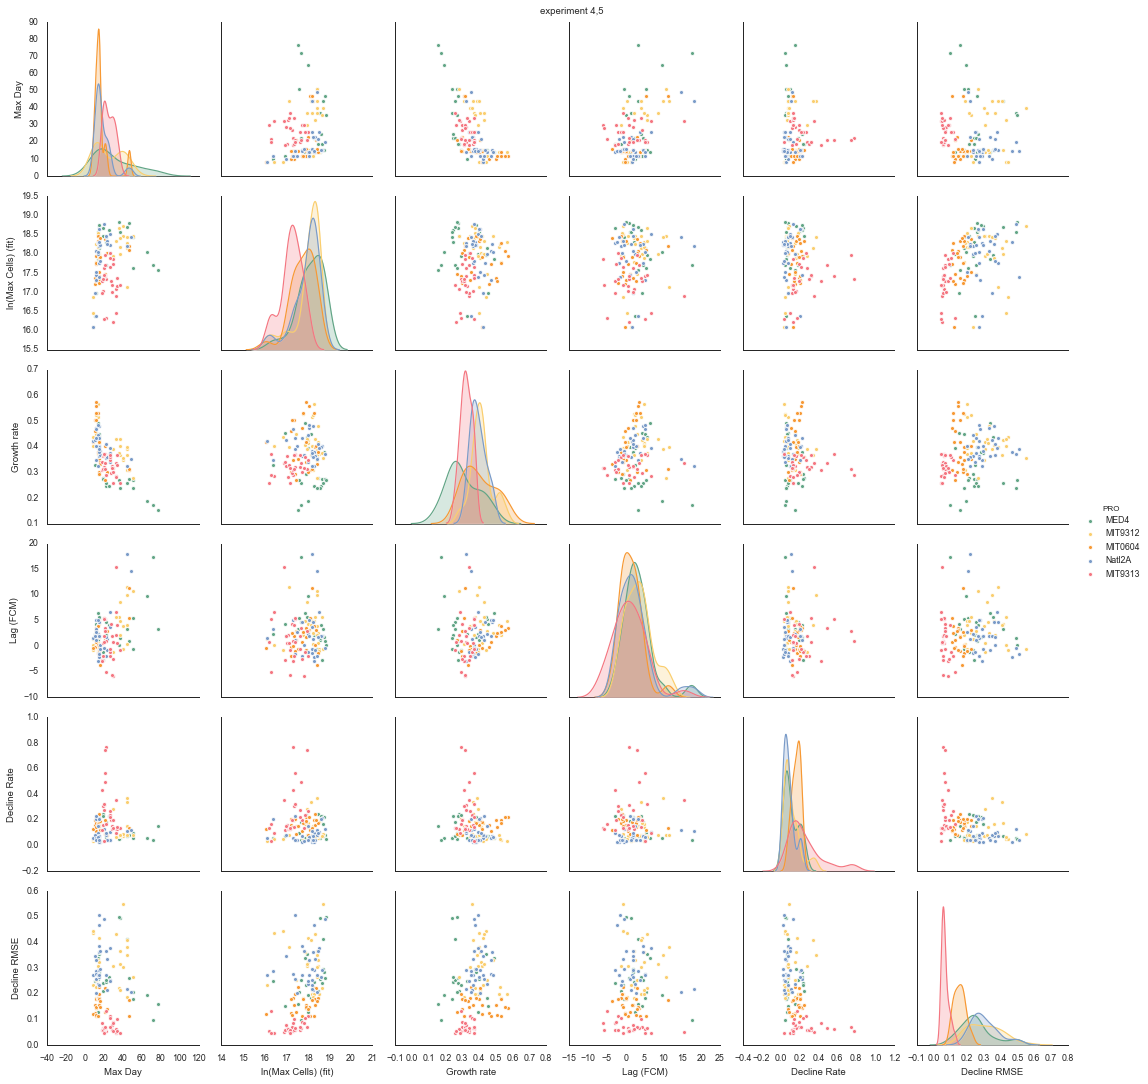

In [33]:
#sns.pairplot(data=cdf.loc[cdf.culture.isin(['Co_Culture']) & cdf.experiment.isin(['e1'])])
sns.set_context('paper')
g = sns.pairplot(cdf.loc[cdf.culture.isin(['Co_Culture']) & cdf.experiment.isin(['e4', 'e5'])
                         & (cdf['Lag (FCM)'] >-10),
                         
                         ['Max Day', 'ln(Max Cells) (fit)', #'ln(Init Cells) (fit)', 
                          'Growth rate',
       #'r2 (growth fit)',  #'ln(Init Cells) (FCM)',
                          'Lag (FCM)',
       'Decline Rate', 'Decline RMSE', 'PRO']
                        ], 
                 hue="PRO", #hue_kws={"cmap": ["Blues", "Greens", "Reds"]}
                 hue_order=porder, palette=ppallete,
                 #s=70,
                 plot_kws={"s": 15}
                )
#g = g.map_diag(sns.kdeplot)
#g = g.map_offdiag(sns.kdeplot)
plt.suptitle('experiment 4,5', y=1)
plt.show()

In [16]:
cdf.columns

Index(['experiment', 'sample', 'PRO', 'ALT', 'culture', 'experiment_sample',
       'Max Day', 'ln(Max Cells) (fit)', 'ln(Init Cells) (fit)', 'Growth rate',
       'r2 (growth fit)', 'Lag (fit)', 'ln(Init Cells) (FCM)', 'Lag (FCM)',
       'Decline Rate', 'Decline RMSE', 'harmonic decline rate',
       'harmonic decline RMSE'],
      dtype='object')

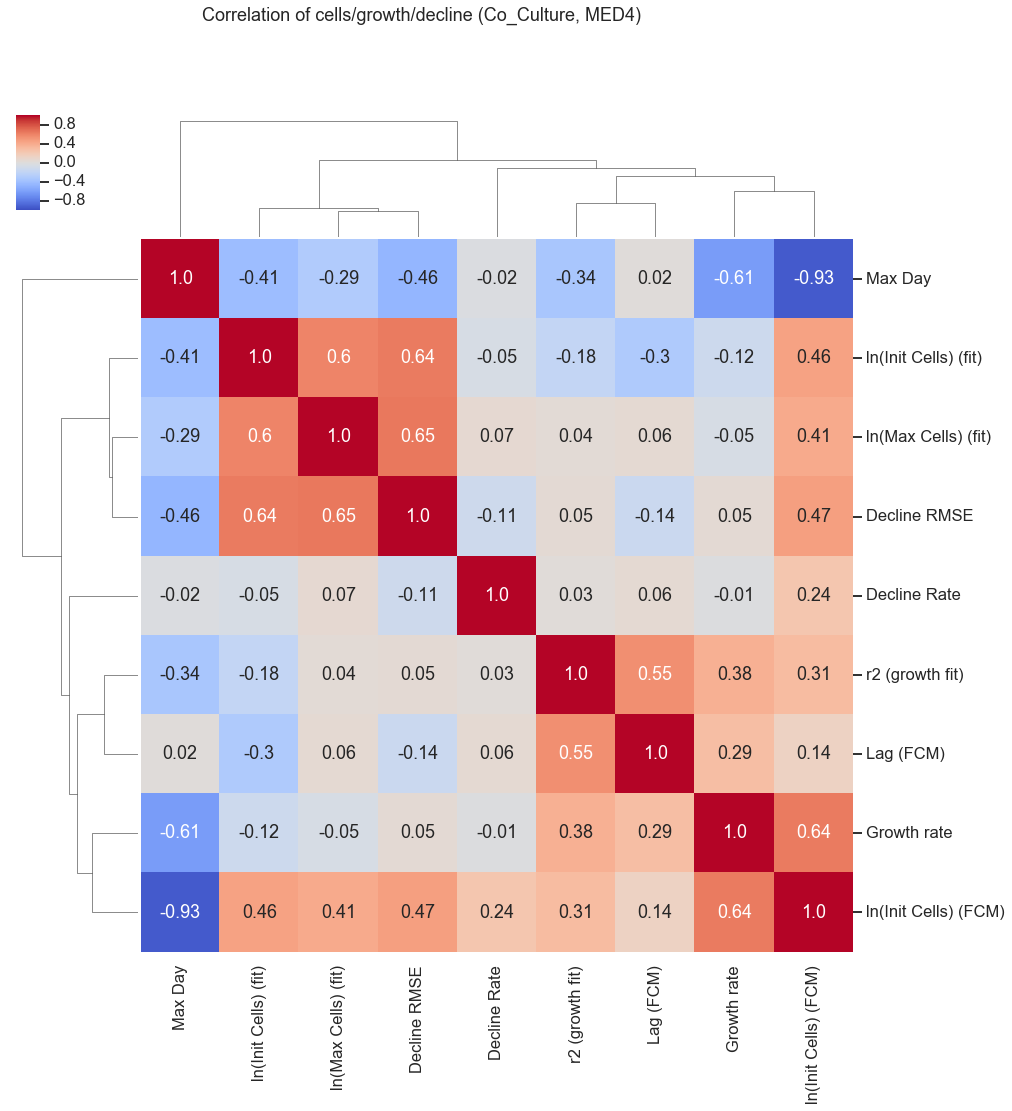

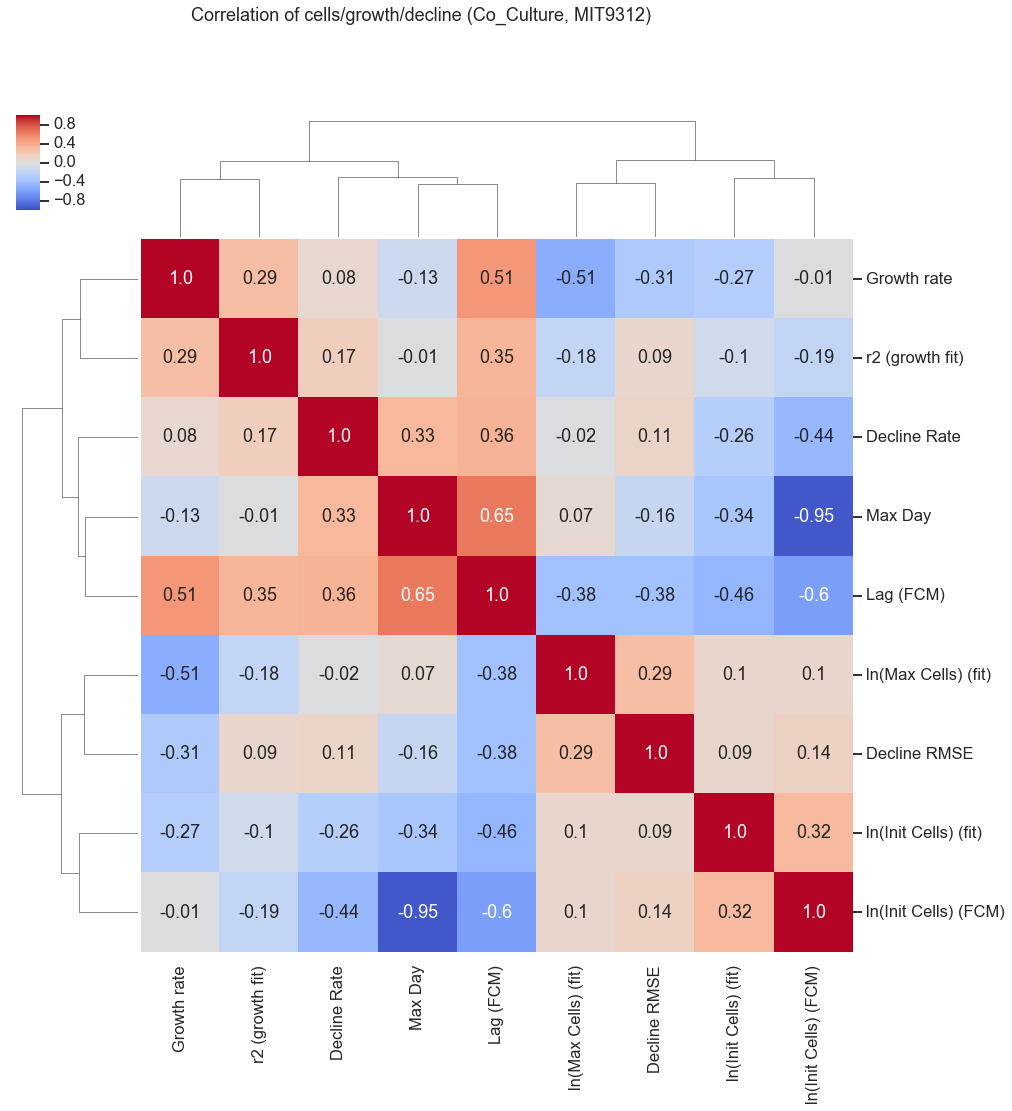

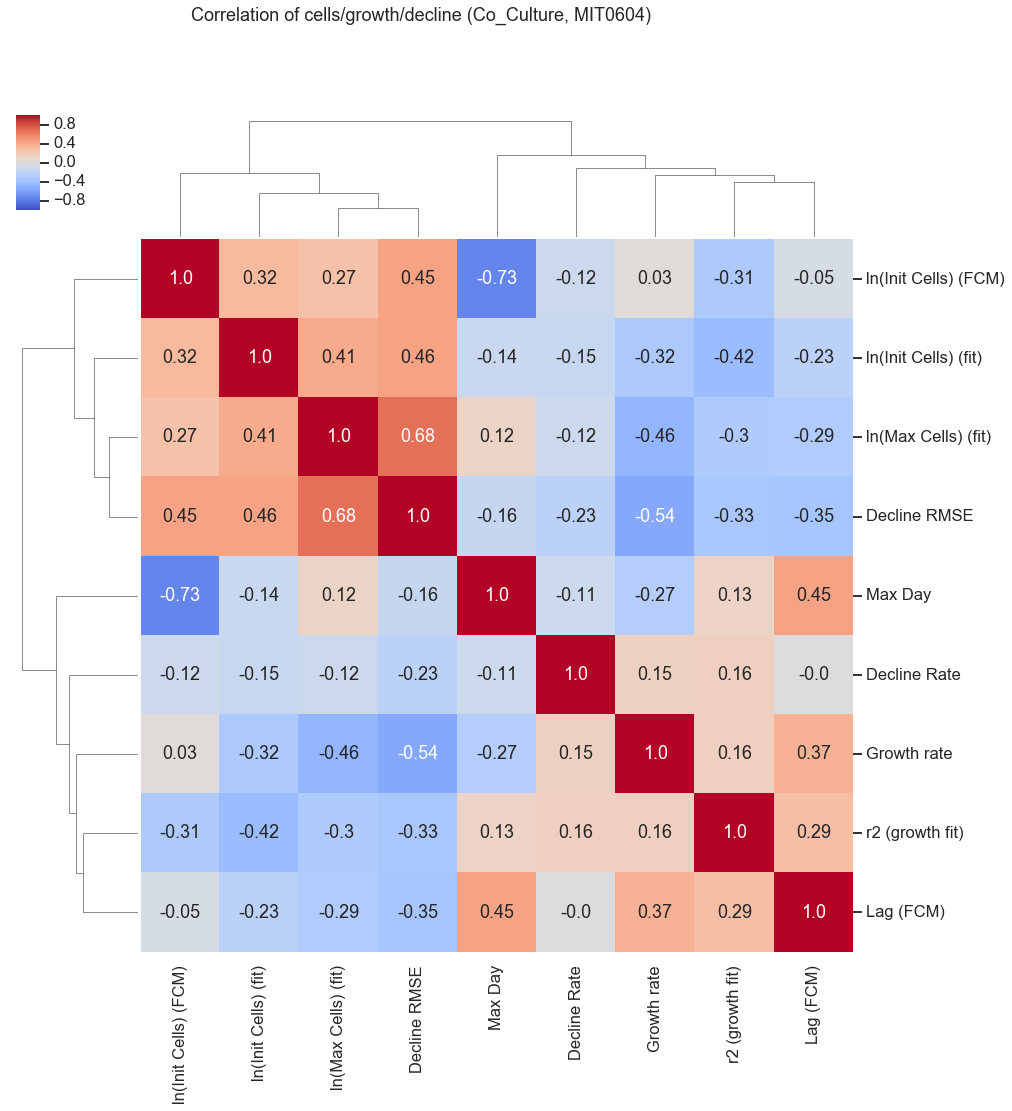

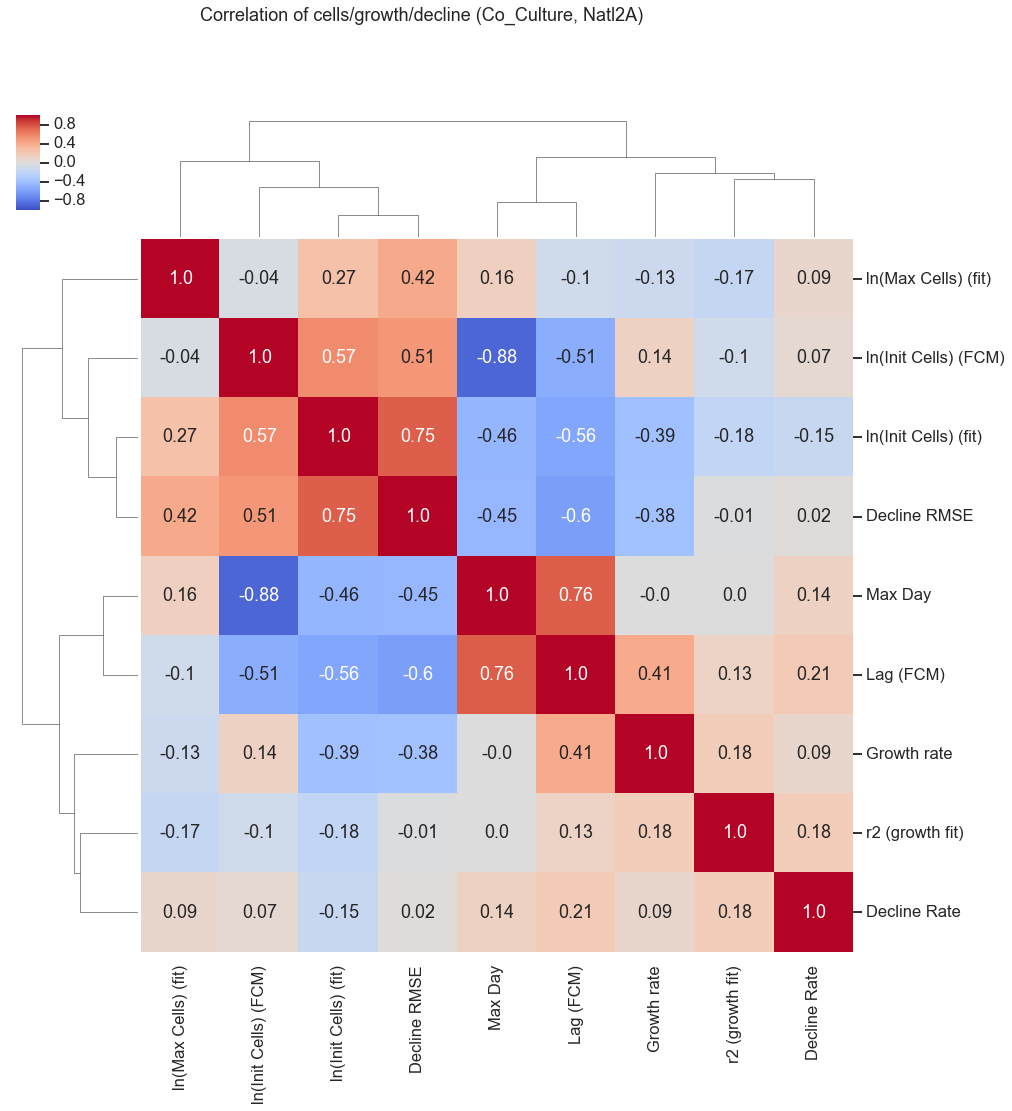

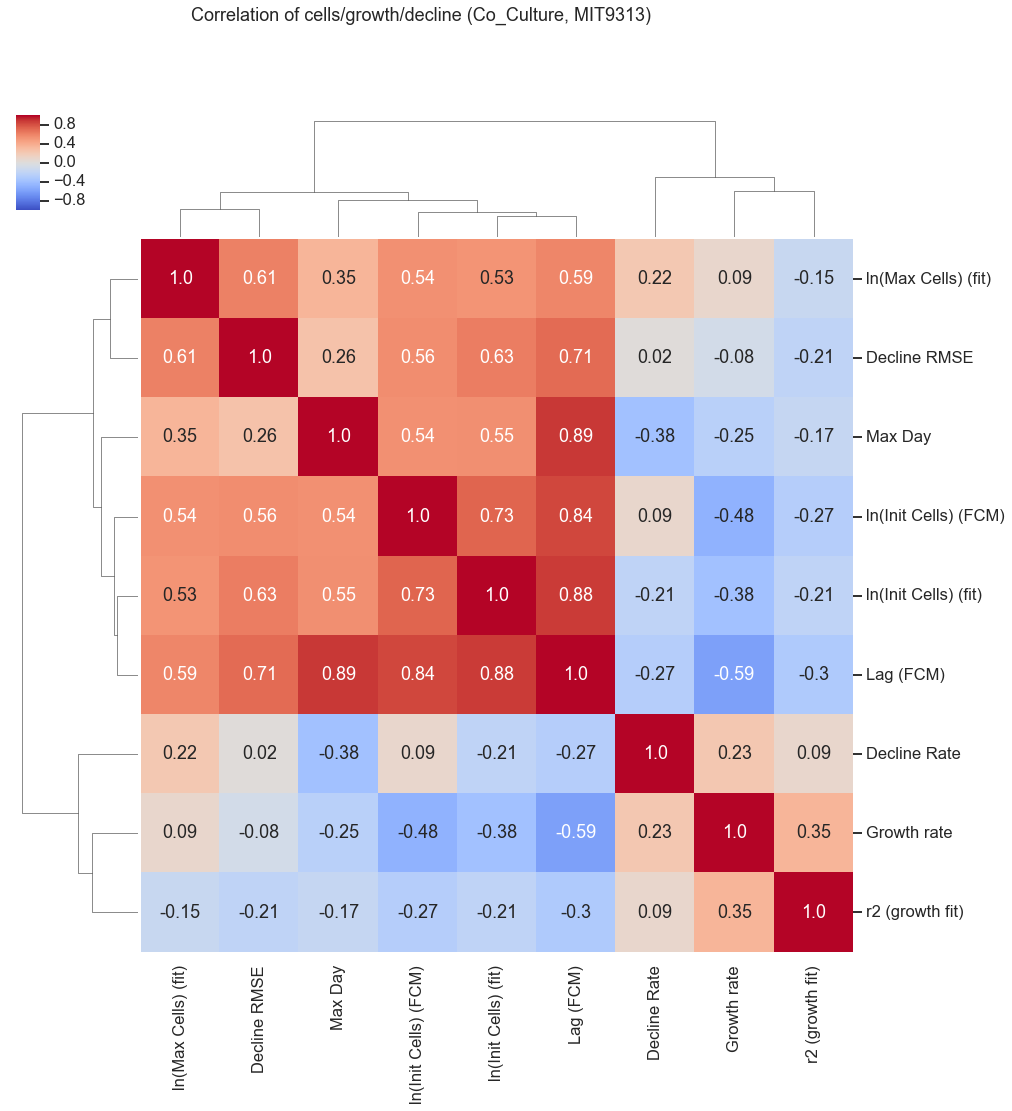

In [17]:
sns.set_style('white')
sns.set_context('talk')
c= 'Co_Culture'
for p in porder:
    sns.clustermap((cdf.loc[cdf.culture.isin([c]) & cdf.PRO.isin([p]),
                            ['Max Day', 'ln(Max Cells) (fit)', 'ln(Init Cells) (fit)', 'Growth rate',
       'r2 (growth fit)',  'ln(Init Cells) (FCM)', 'Lag (FCM)',
       'Decline Rate', 'Decline RMSE',]
                           ].corr().round(2)), 
                figsize=(15,15),
                cmap='coolwarm', annot=True,  fmt='.2',
                vmin=-1, vmax=1,
               )
    plt.suptitle(f'Correlation of cells/growth/decline ({c}, {p})', y=1)


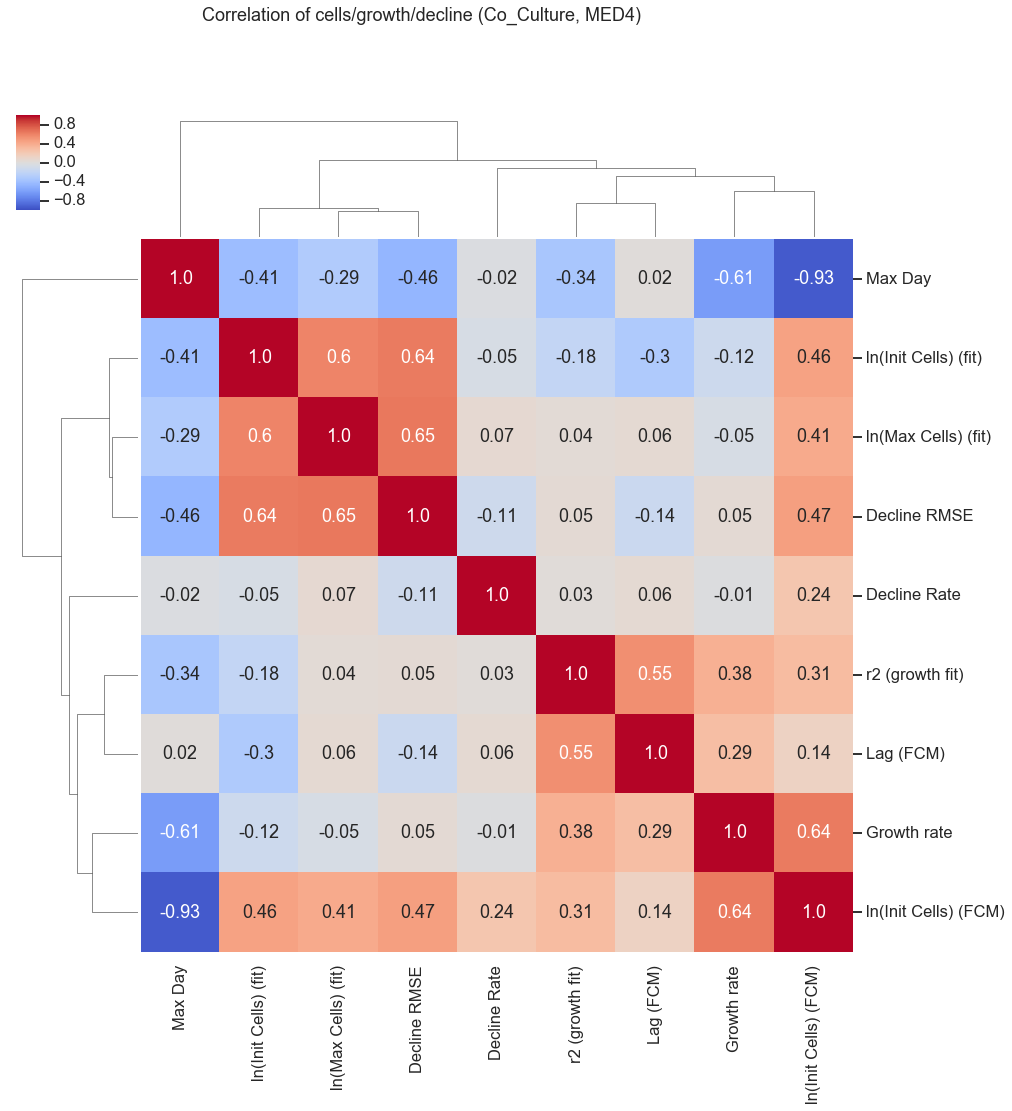

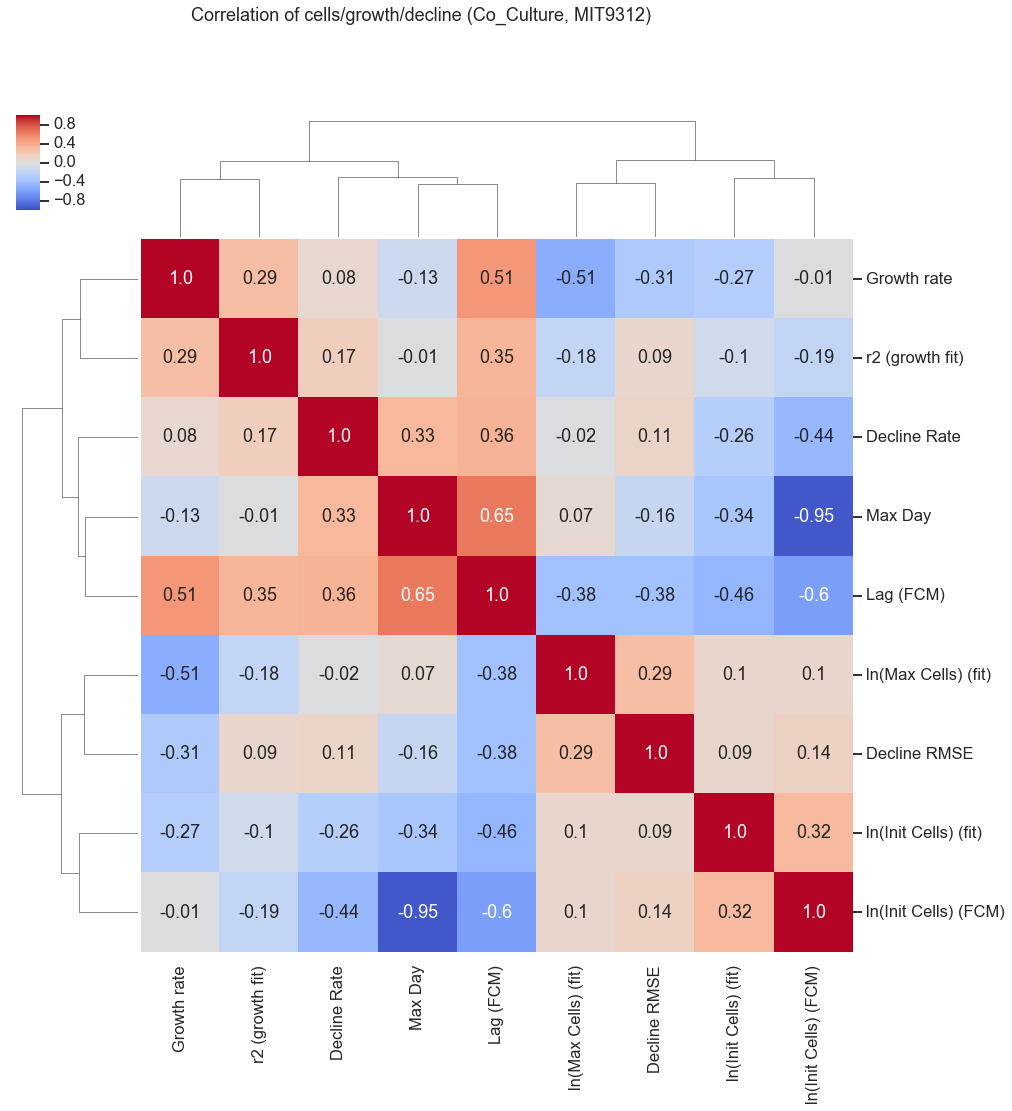

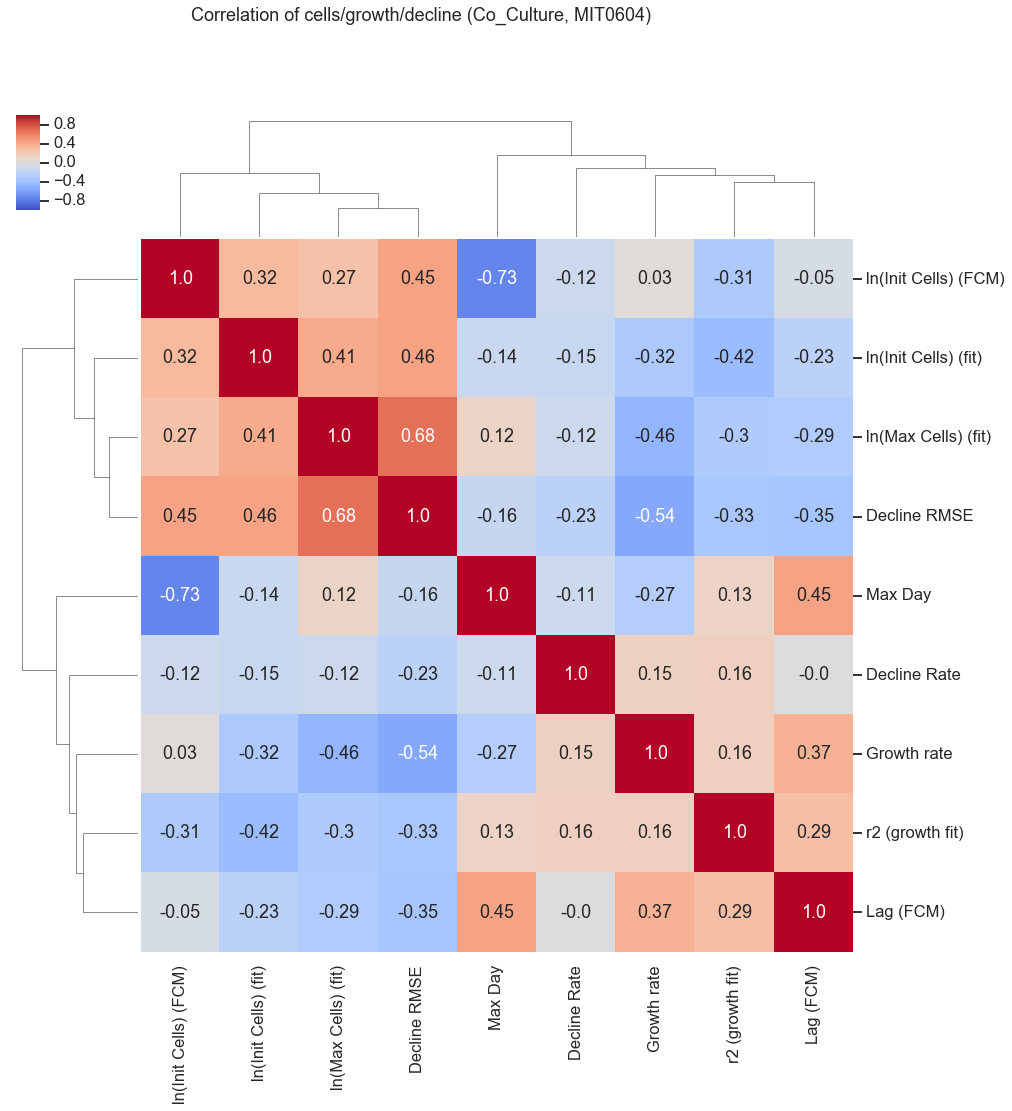

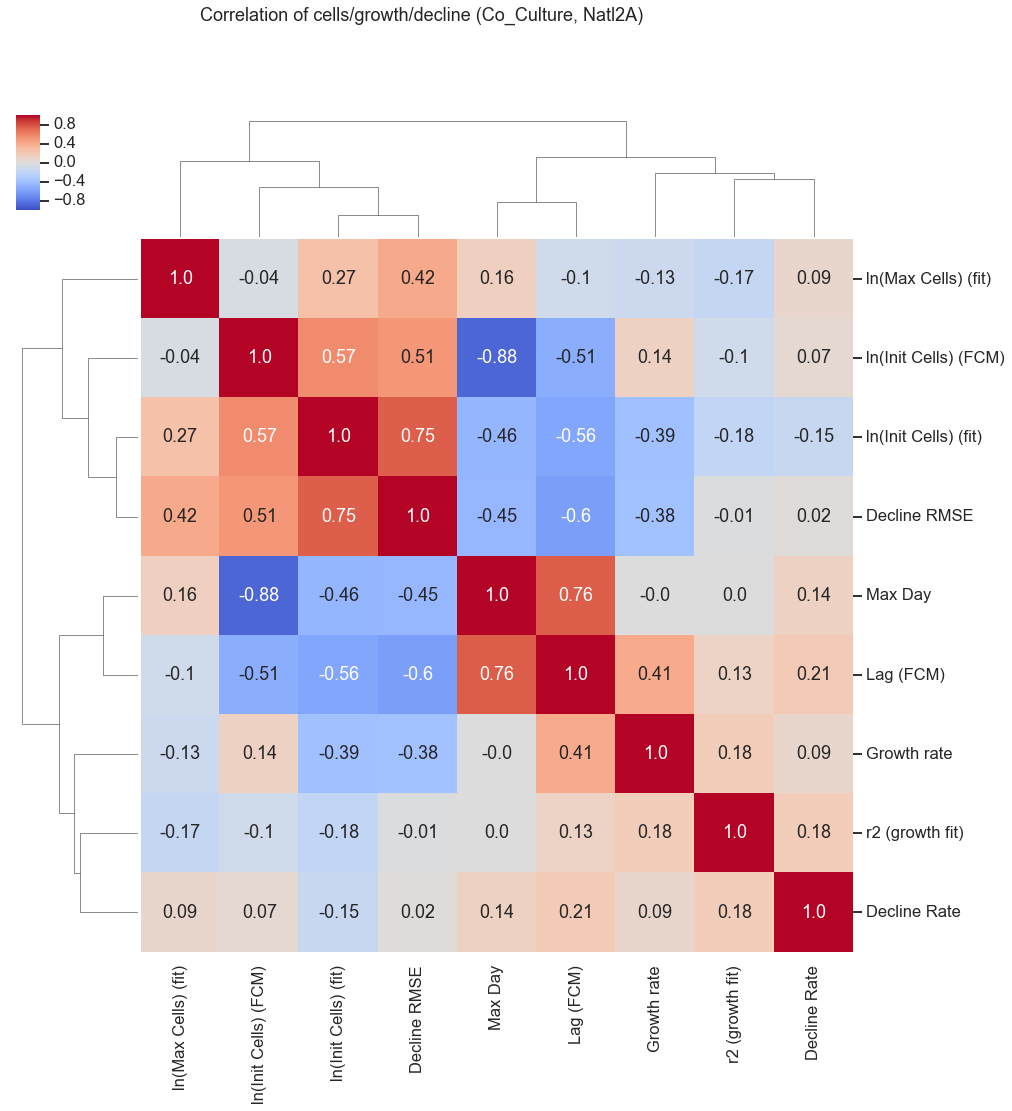

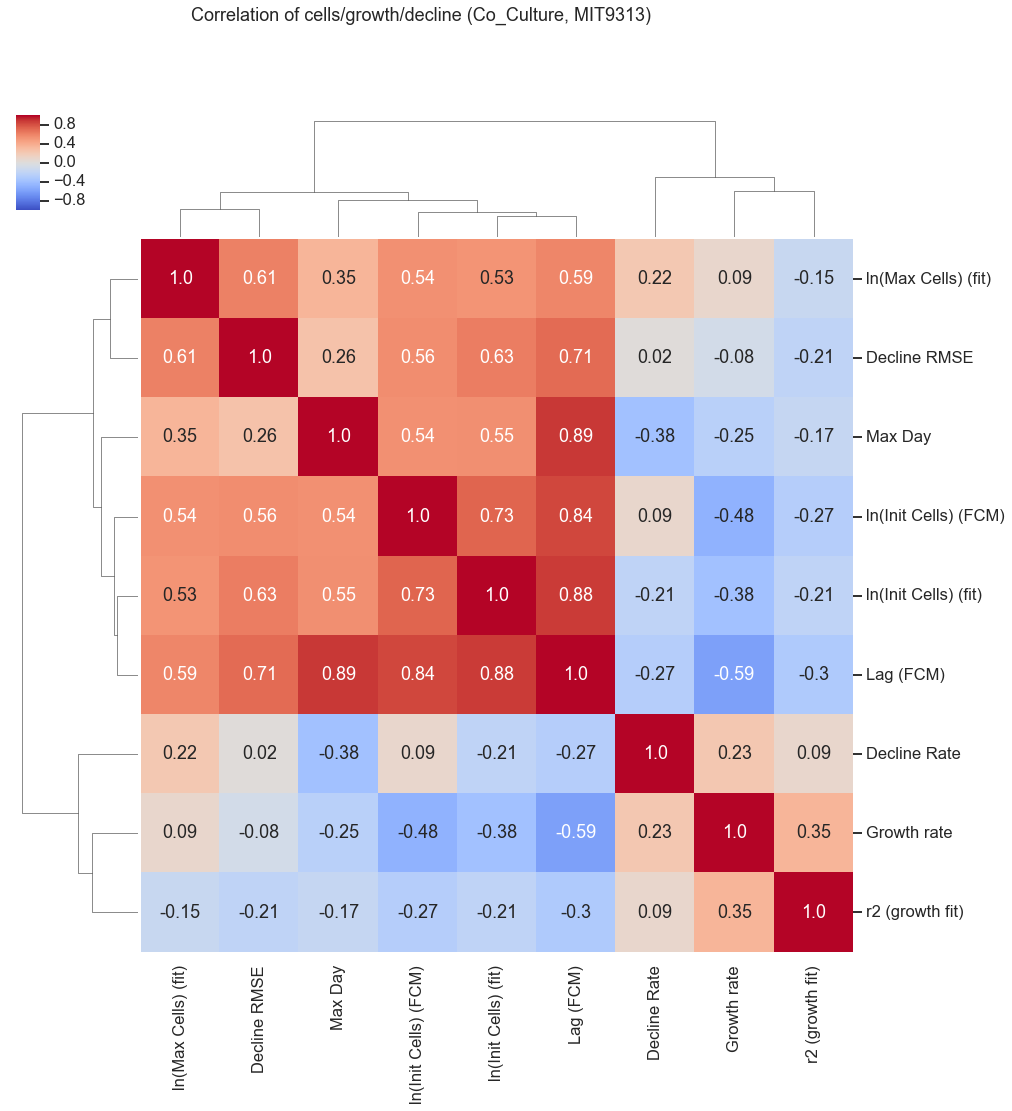

In [18]:
sns.set_style('white')
sns.set_context('talk')
c= 'Co_Culture'
for p in porder:
    sns.clustermap((cdf.loc[cdf.culture.isin([c]) & cdf.PRO.isin([p]),
                            ['Max Day', 'ln(Max Cells) (fit)', 'ln(Init Cells) (fit)', 'Growth rate',
       'r2 (growth fit)',  'ln(Init Cells) (FCM)', 'Lag (FCM)',
       'Decline Rate', 'Decline RMSE',]
                           ].corr().round(2)), 
                figsize=(15,15),
                cmap='coolwarm', annot=True,  fmt='.2',
                vmin=-1, vmax=1,
               )
    plt.suptitle(f'Correlation of cells/growth/decline ({c}, {p})', y=1)
